# Gerekli Libleri Import Etme

In [42]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from numpy.random import seed
from scipy.special import softmax

# DataSeti tanımlama, gereksiz columnları temizleme ve float,int olmayan değerleri unique değerlerle doldurma

In [43]:
df_main = pd.read_csv("One_year_compiled.csv")


def handle_non_numeric(df):
    # Values in each column for each column
    columns = df.columns.values
    
    for column in columns:
        
        # Dictionary with each numerical value for each text
        text_digit_vals = {}
        
        # Receives text to convert to a number
        def convert_to_int (val):
            
            # Returns respective numerical value for class
            return text_digit_vals[val]
        
        # If values in columns are not float or int
        if df[column].dtype !=np.int64 and df[column].dtype != np.float64:
            
            # Gets values form current column
            column_contents = df[column].values.tolist()
            
            # Gets unique values from current column
            unique_elements = set(column_contents)
            
            # Classification starts at 0
            x=0
            
            for unique in unique_elements:
                
                # Adds the class value for the text in dictionary, if it's not there
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1
            
            # Maps the numerical values to the text values in columns 
            df[column] = list(map(convert_to_int, df[column]))
    
    return df

df_clear = df_main.drop(['day', 'sample_Number', 'month', 'timestamp'], axis=1)

df_clear = handle_non_numeric(df_clear)

X = df_clear

# Verileri normalize edip , ön işlemesini yapıp ölçeklendirme 

In [44]:

scaler = preprocessing.StandardScaler()
#Preprocessing
X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)


#Scaling
X = preprocessing.scale(X)
#Splitting the feature data for training data. First 10.000 rows.
X_train = X[:10000]

# OC SVM Modelini oluşturma 

In [45]:
pred_df = pd.DataFrame()


# nu, destek vektörlerinin yüzdesini kontrol eder.
# gamma, SVM'in karar fonksiyonunu nasıl hesaplayacağını belirler.
ocsvm = OneClassSVM(nu=0.25, gamma=0.05)
ocsvm.fit(X_train)

df=df_clear.copy()
pred_df['pred_anomaly'] = pd.Series(ocsvm.predict(X_train))

pred_df.to_csv('Labled_df.csv')

pred_df = pd.read_csv('Labled_df.csv', index_col=0)
pred_df['Index'] = range(len(pred_df))


df_clear['Index'] = range(len(df_clear))



#Getting labled groups
scat_1 = pred_df.groupby('pred_anomaly').get_group(1)
scat_0 = pred_df.groupby('pred_anomaly').get_group(-1)

In [46]:
# pred_df'den istediğimiz sütunları seçelim
istenen_sutunlar_pred = ['pred_anomaly'] 

# pred_df'den seçilen sütunları içeren bir DataFrame oluşturalım
istenen_sutunlar_df = pred_df[istenen_sutunlar_pred]

# df_clear ile istenen sütunları birleştirelim
df_clear = pd.concat([df_clear, istenen_sutunlar_df], axis=1)

df_clear2 = df_clear[:10000]


In [47]:
scat_0['pCut::Motor_Torque'] = df_clear2['pCut::Motor_Torque']
scat_1['pCut::Motor_Torque'] = df_clear2['pCut::Motor_Torque']

scat_0['hour'] = df_clear2['hour']
scat_1['hour'] = df_clear2['hour']

/var/folders/yf/mdvk03ms7dd5grqgsv4h23p00000gn/T/ipykernel_1558/1647032513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scat_0['pCut::Motor_Torque'] = df_clear2['pCut::Motor_Torque']
/var/folders/yf/mdvk03ms7dd5grqgsv4h23p00000gn/T/ipykernel_1558/1647032513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scat_1['pCut::Motor_Torque'] = df_clear2['pCut::Motor_Torque']
/var/folders/yf/mdvk03ms7dd5grqgsv4h23p00000gn/T/ipykernel_1558/1647032513.py:4: SettingWithCopyWarning: 
A value is trying to be se

# Görselleştirme

<Axes: >

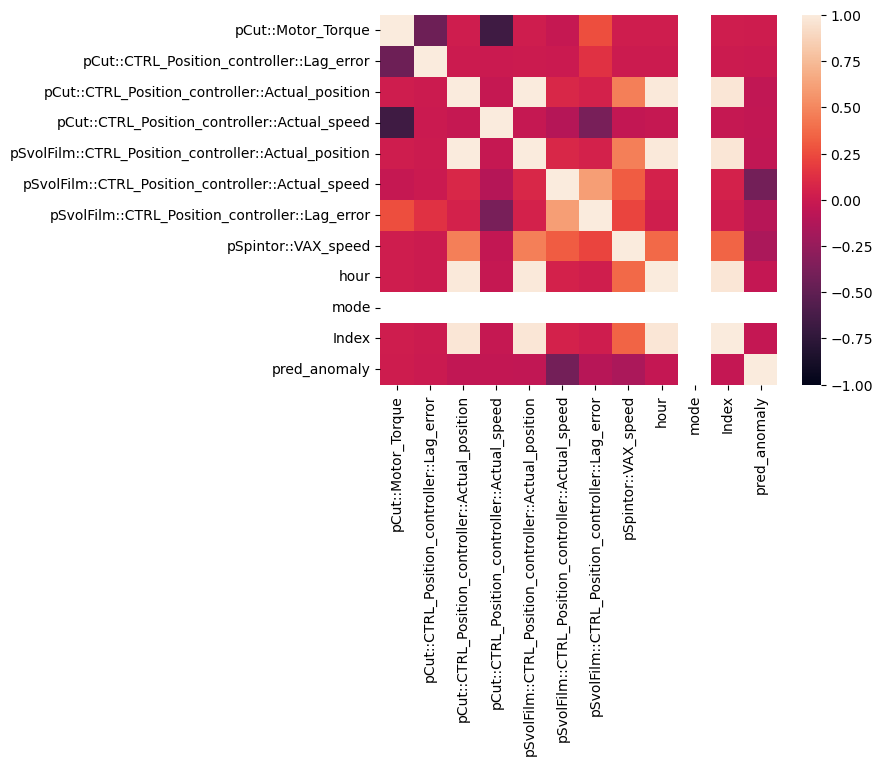

In [48]:
sns.heatmap(df_clear2.corr(), vmin= -1, vmax = 1)

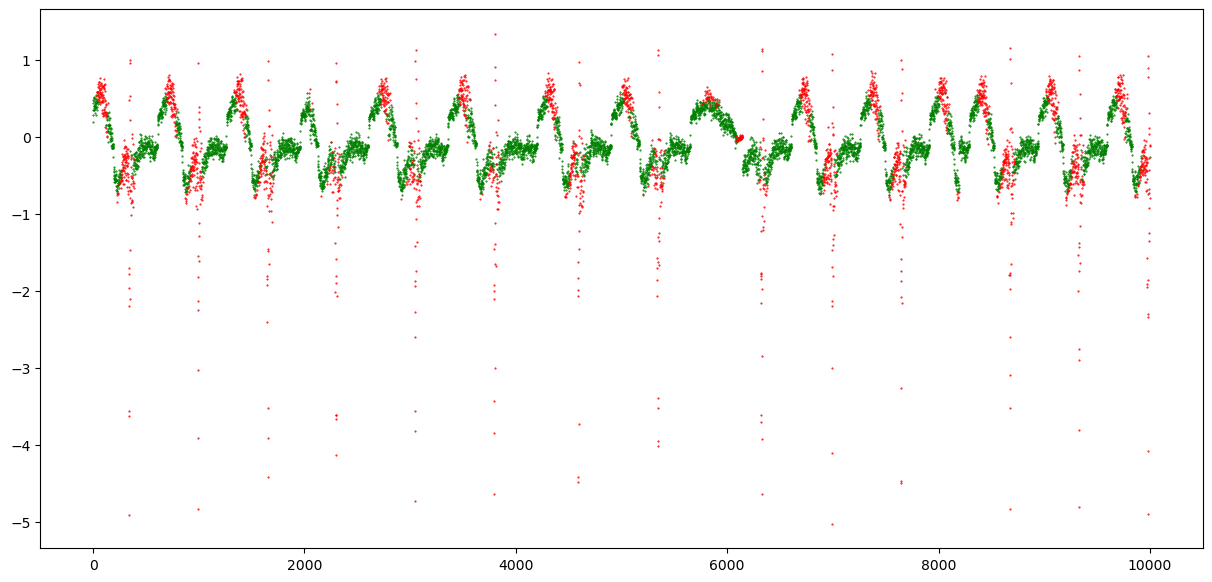

In [49]:
# Plot size
plt.subplots(figsize=(15,7))

# Plot group 1 -labeled, color green, point size 1
plt.plot(scat_1.index,scat_1['pCut::Motor_Torque'], 'g.', markersize=1)

# Plot group -1 -labeled, color red, point size 1
plt.plot(scat_0.index, scat_0['pCut::Motor_Torque'],'r.', markersize=1)

/var/folders/yf/mdvk03ms7dd5grqgsv4h23p00000gn/T/ipykernel_1558/1539829094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clear2.rename(columns={"pCut::Motor_Torque" : "pCut_Motor_Torque"},inplace=True)


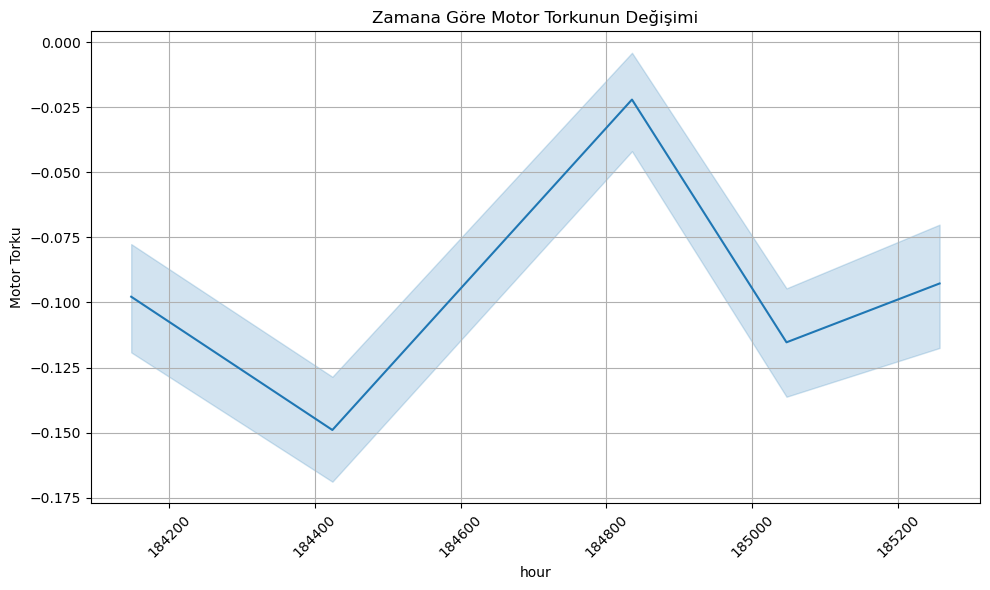

In [50]:
df_clear2.rename(columns={"pCut::Motor_Torque" : "pCut_Motor_Torque"},inplace=True)



plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='pCut_Motor_Torque', data=df_clear2)
plt.title('Zamana Göre Motor Torkunun Değişimi')
plt.xlabel('hour')
plt.ylabel('Motor Torku')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

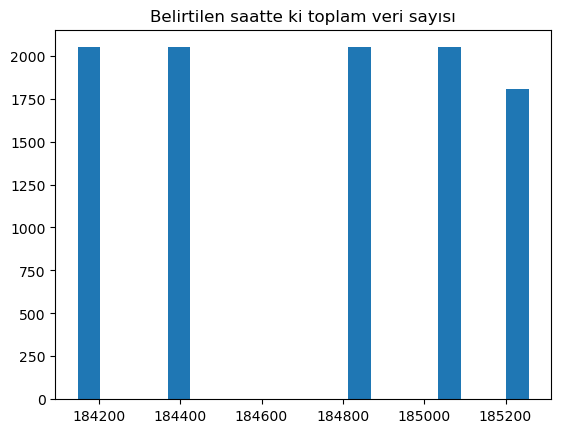

In [51]:
plt.hist(df_clear2.hour, bins = 20)
plt.title("Belirtilen saatte ki toplam veri sayısı")
plt.show()

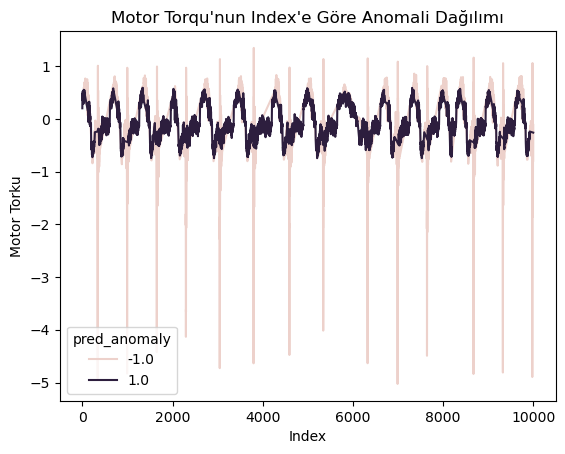

In [52]:
sns.lineplot(
    x="Index",
    y="pCut_Motor_Torque",
    hue="pred_anomaly",
    data=df_clear2,
    
)
plt.title("Motor Torqu'nun Index'e Göre Anomali Dağılımı")
plt.xlabel("Index")
plt.ylabel("Motor Torku")
plt.show()

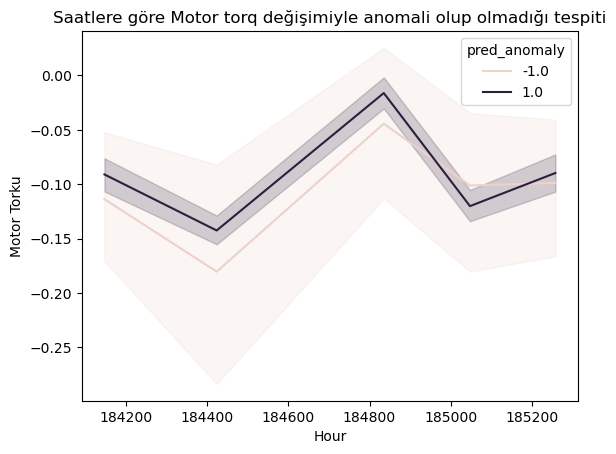

In [53]:
sns.lineplot(x="hour", y="pCut_Motor_Torque", data=df_clear2, hue="pred_anomaly")
plt.xlabel("Hour")
plt.ylabel("Motor Torku")
plt.title("Saatlere göre Motor torq değişimiyle anomali olup olmadığı tespiti")
plt.show()


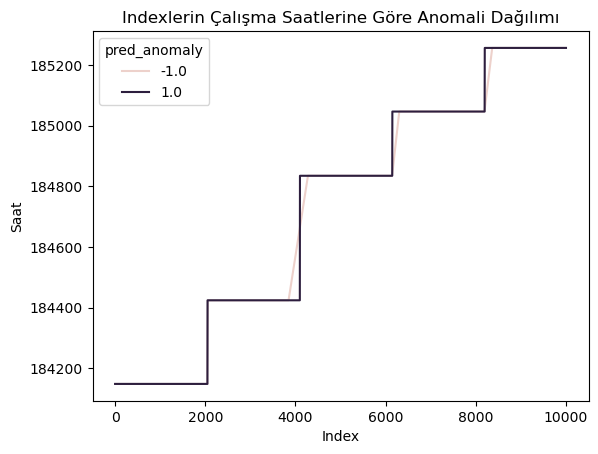

In [54]:
sns.lineplot(
    x="Index",
    y="hour",
    hue="pred_anomaly",
    data=df_clear2,
    
)
plt.title("Indexlerin Çalışma Saatlerine Göre Anomali Dağılımı")
plt.xlabel("Index")
plt.ylabel("Saat")
plt.show()

In [55]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(pred_df, test_size=0.5, random_state=42)


In [56]:
df_clear2

,pCut_Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed,hour,mode,Index,pred_anomaly
0,0.199603,0.027420,628392628,-920.104980,5298555,2441.235352,0.899543,1379.999756,184148.0,5,0,1.0
1,0.281624,0.002502,628392625,-937.271118,5298565,2453.819092,0.874072,1379.999756,184148.0,5,1,1.0
2,0.349315,-0.018085,628392621,-951.004028,5298575,2476.469727,0.879806,1379.999756,184148.0,5,2,1.0
3,0.444450,-0.054680,628392617,-1019.668579,5298585,2501.637207,0.837500,1379.999756,184148.0,5,3,1.0
4,0.480923,-0.042770,628392613,-1023.101807,5298595,2519.254395,0.905347,1379.999756,184148.0,5,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.276328,-0.074609,629074147,5788.421387,6986737,3181.156494,0.729632,1379.999756,185257.0,5,9995,-1.0
9996,-0.098007,-0.111514,629074169,5730.056641,6986750,3168.572754,0.747087,1379.999756,185257.0,5,9996,-1.0
9997,-0.110820,-0.087996,629074192,5661.392090,6986763,3254.141602,0.677096,1379.999756,185257.0,5,9997,-1.0
9998,-0.794473,0.151855,629074214,5575.561523,6986776,3148.438721,0.645075,1379.999756,185257.0,5,9998,-1.0


In [57]:
train_df = train_df.drop('Index', axis=1)

In [58]:
test_df = test_df.drop('Index', axis=1)

In [59]:
train_df.replace(-1, 0, inplace=True)

In [60]:
test_df.replace(-1, 0, inplace=True)

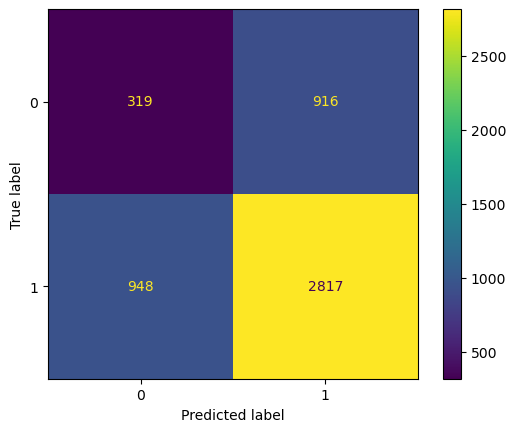

In [61]:

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(train_df, test_df)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [62]:
Accuracy = metrics.accuracy_score(train_df, test_df)
print("ACC SCORE :" , Accuracy)

F1_score = metrics.f1_score(train_df, test_df)
print("F1 SCORE", F1_score)

Precision = metrics.precision_score(train_df, test_df)
print("Precision : ", Precision)

Recall = metrics.recall_score(train_df, test_df)
print("Recall : ", Recall) 

ACC SCORE : 0.6272
F1 SCORE 0.7514003734329155
Precision :  0.7546209482989553
Recall :  0.748207171314741
